Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 93s 5s/step - accuracy: 0.1564 - loss: 2.6062 - val_accuracy: 0.4125 - val_loss: 1.8467
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 92s 5s/step - accuracy: 0.5743 - loss: 1.2761 - val_accuracy: 0.4375 - val_loss: 1.6398
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 87s 4s/step - accuracy: 0.8203 - loss: 0.6978 - val_accuracy: 0.4625 - val_loss: 1.4740
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 92s 5s/step - accuracy: 0.9333 - loss: 0.4400 - val_accuracy: 0.5625 - val_loss: 1.2784
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 88s 4s/step - accuracy: 0.9920 - loss: 0.2593 - val_accuracy: 0.5250 - val_loss: 1.2197
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 88s 4s/step - accuracy: 0.9993 - loss: 0.1827 - val_accuracy: 0.5375 - val_loss: 1.2311
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 92s 5s/step - accuracy: 0.9986 - loss: 0.1544 - val_accuracy: 0.5875 - val_loss: 1.1346
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 88s 4s/step - accuracy: 0.9973 - loss: 0.1245 - val_accuracy: 0.6000 - val_loss:

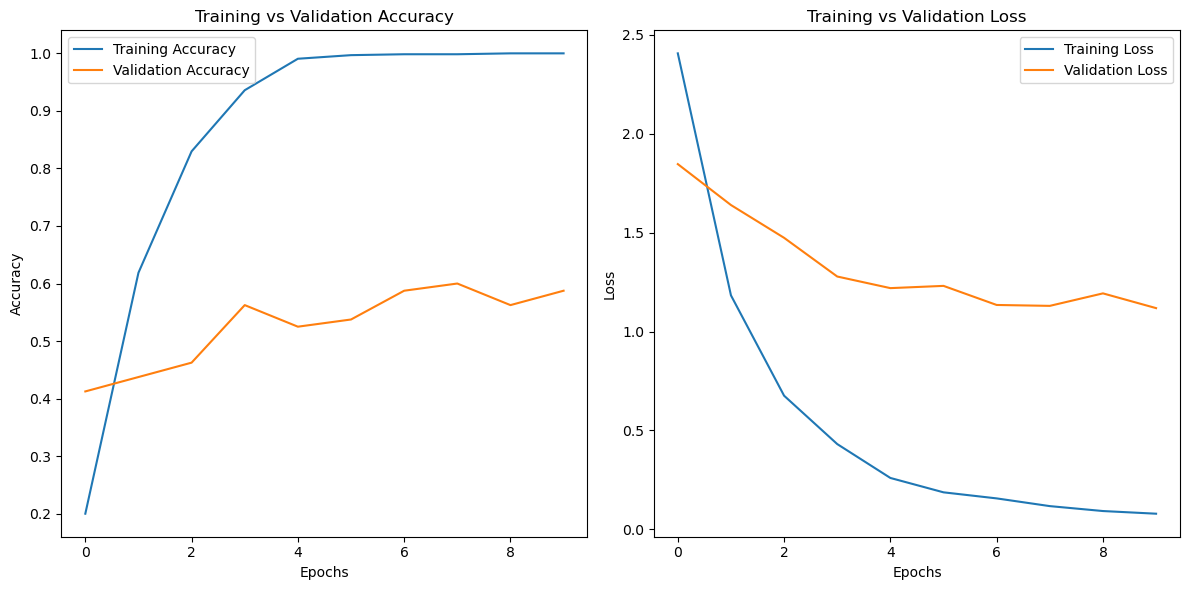

Enter the path to the image you want to test: C:\Users\Laptop\Desktop\CV\Pothole detection\Face_recognition\Celebrity Faces Dataset\Johnny Depp\074_bd6f3a84.jpg


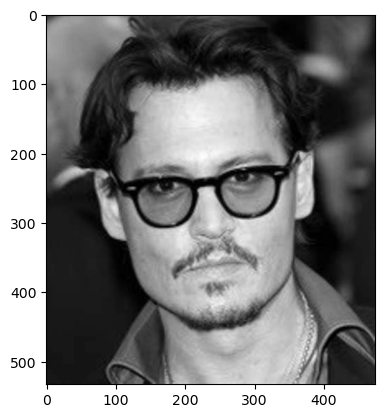

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
The predicted actor is: Johnny Depp


In [1]:
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten
from tensorflow.keras.applications import VGG16
from sklearn.metrics import f1_score, recall_score
import seaborn as sns
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import cv2

# Dictionary mapping actor names to numeric labels
y_vals = {
    "Brad Pitt": 0,
    "Hugh Jackman": 1,
    "Johnny Depp": 2,
    "Leonardo DiCaprio": 3,
    "Robert Downey Jr": 4,
    "Tom Cruise": 5,
    "Tom Hanks": 6,
    "Will Smith": 7,
}

dataset = r"C:\Users\Laptop\Desktop\CV\Pothole detection\Face_recognition\Celebrity Faces Dataset"

# Update image loading and resizing
def load_imgs(dataset_path, label_map):
    images, labels = [], []
    for actor, label in label_map.items():
        actor_folder = os.path.join(dataset_path, actor)
        
        if not os.path.exists(actor_folder):
            print(f"Folder not found: {actor_folder}")
            continue
        
        for img_name in os.listdir(actor_folder):
            img_path = os.path.join(actor_folder, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            
            if img is not None:
                img = cv2.resize(img, (200, 200))  # Resize images to 200x200
                
                # Convert grayscale to RGB (repeat the single channel)
                img_rgb = np.repeat(img[..., np.newaxis], 3, axis=-1)  # Repeat the grayscale channel 3 times
                
                images.append(img_rgb)
                labels.append(label)
    
    return np.array(images), np.array(labels)

X, y = load_imgs(dataset, y_vals)

# Normalize image pixel values
X = X / 255.0  # Normalize to range [0, 1]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Convert data to TensorFlow datasets
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(1000).batch(32)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32)

# Load the VGG16 model pre-trained on ImageNet and exclude its top layers
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(200, 200, 3))

# Freeze the convolutional layers
vgg_base.trainable = False

# Build the model using the pre-trained VGG16
model = Sequential([
    vgg_base,
    Flatten(),
    Dense(8, activation='softmax')  # 8 classes for 8 actors
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_ds, validation_data=val_ds, epochs=10)

# Evaluate the model on the test set
y_true, y_pred = [], []
for images, labels in test_ds:
    predictions = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

# Compute metrics
f1 = f1_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')

print(f"F1 Score: {f1}")
print(f"Recall: {recall}")

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Save the model
model.save("face_recognition_vgg16_model.keras")


def predict_actor(image_path, model, labels):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    plt.imshow(img, cmap='gray')
    plt.show()
    img = cv2.resize(img, (200, 200)) / 255.0
    img = np.expand_dims(img, axis=-1)  # Add channel dimension
    img = np.repeat(img, 3, axis=-1)  # Convert grayscale to RGB
    prediction = np.argmax(model.predict(np.expand_dims(img, 0)))
   
    return {v: k for k, v in labels.items()}.get(prediction, "Unknown")


if __name__ == "__main__":
    img_path = input("Enter the path to the image you want to test: ")
    print(f"The predicted actor is: {predict_actor(img_path, model, y_vals)}")


In [ ]:
# . Importing Required Libraries
# numpy: For numerical operations and handling image arrays.
# os: To navigate the file system and access directories/files.
# tensorflow: For building and training the deep learning model.
# matplotlib.pyplot: For plotting accuracy and loss graphs.
# cv2: From OpenCV, used for image processing, like reading and resizing.
# sklearn: For metrics like f1_score and recall_score.
# seaborn: For creating aesthetic plots.

# 2. Label Dictionary
# Maps actor names to numeric labels for classification. Example: "Brad Pitt": 0.

# 3. Loading and Preprocessing Images
# Function load_imgs:
# Iterates through the folders of actors.
# Reads grayscale images using cv2.imread() with cv2.IMREAD_GRAYSCALE.
# Resizes them to 200x200 using cv2.resize().
# Converts grayscale to RGB by repeating the grayscale channel 3 times with np.repeat(). This is needed because VGG16 expects 3-channel RGB images.

# 4. Dataset Splitting
# Images (X) and labels (y) are split into training, validation, and test sets using train_test_split with an 80-10-10 ratio.

# 5. Normalization
# Normalizes image pixel values to the range [0, 1] by dividing by 255.

# 6. TensorFlow Datasets
# Converts NumPy arrays into TensorFlow tf.data.Dataset for efficient input pipeline and batching.

# 7. Model Architecture: VGG16
# Pre-trained VGG16:
# Loaded without the top layers using include_top=False.
# Trained on ImageNet for general features like edges, textures, and patterns.
# The trainable attribute is set to False to freeze weights in pre-trained layers.
# Custom Top Layers:
# A Flatten layer to convert 3D feature maps into a 1D vector.
# A Dense layer with 8 neurons (one for each actor) and softmax activation for classification.

# 8. Model Compilation
# adam optimizer: For adaptive learning rates.
# sparse_categorical_crossentropy: Handles integer labels directly (e.g., 0-7).
# Metrics: Tracks accuracy during training and evaluation.

# 9. Model Training
# Trained using model.fit() for 10 epochs. The history object stores metrics like accuracy and loss for plotting.

# 10. Evaluation
# Predictions are made on the test set, and metrics like F1 Score and Recall are computed.

# 11. Visualization
# Plots training and validation accuracy/loss to analyze overfitting or underfitting trends.

# 12. Saving the Model
# Saves the trained model using model.save().

# 13. Prediction Function
# predict_actor:
# Takes an input image, processes it (grayscale -> resize -> RGB conversion).
# Predicts the class (actor name) using the trained model.
# Converts numeric predictions back to actor names using the inverse of the label dictionary.



# 1. Architecture Overview
# VGG16 consists of:

# 13 Convolutional Layers: These are used to extract features from input images.
# 5 Max-Pooling Layers: These are used to reduce the spatial dimensions of feature maps.
# 3 Fully Connected (FC) Layers: These layers are used for final classification and decision-making.
# Softmax Layer: The output layer that provides probabilities for each class.
# The network uses very small filters of size 3x3 in convolutional layers with a stride of 1, and max-pooling layers with a pool size of 2x2 and a stride of 2.

# 2. Layer-by-Layer Breakdown
# Input Layer
# Input Size: The input is an image with dimensions of 224x224x3 (height, width, channels). This means the image is resized to 224x224 pixels, and there are 3 channels for RGB images.

# First Convolution Block (Block 1)
# Conv Layer 1: 64 filters of size 3x3 with ReLU activation.
# Output size: 224x224x64.
# Conv Layer 2: 64 filters of size 3x3 with ReLU activation.
# Output size: 224x224x64.
# Max-Pooling: Pooling size 2x2 with a stride of 2.
# Output size: 112x112x64.

# Second Convolution Block (Block 2)
# Conv Layer 3: 128 filters of size 3x3 with ReLU activation.
# Output size: 112x112x128.
# Conv Layer 4: 128 filters of size 3x3 with ReLU activation.
# Output size: 112x112x128.
# Max-Pooling: Pooling size 2x2 with a stride of 2.
# Output size: 56x56x128.

# Third Convolution Block (Block 3)
# Conv Layer 5: 256 filters of size 3x3 with ReLU activation.
# Output size: 56x56x256.
# Conv Layer 6: 256 filters of size 3x3 with ReLU activation.
# Output size: 56x56x256.
# Conv Layer 7: 256 filters of size 3x3 with ReLU activation.
# Output size: 56x56x256.
# Max-Pooling: Pooling size 2x2 with a stride of 2.
# Output size: 28x28x256.

# Fourth Convolution Block (Block 4)
# Conv Layer 8: 512 filters of size 3x3 with ReLU activation.
# Output size: 28x28x512.
# Conv Layer 9: 512 filters of size 3x3 with ReLU activation.
# Output size: 28x28x512.
# Conv Layer 10: 512 filters of size 3x3 with ReLU activation.
# Output size: 28x28x512.
# Max-Pooling: Pooling size 2x2 with a stride of 2.
# Output size: 14x14x512.

# Fifth Convolution Block (Block 5)
# Conv Layer 11: 512 filters of size 3x3 with ReLU activation.
# Output size: 14x14x512.
# Conv Layer 12: 512 filters of size 3x3 with ReLU activation.
# Output size: 14x14x512.
# Conv Layer 13: 512 filters of size 3x3 with ReLU activation.
# Output size: 14x14x512.
# Max-Pooling: Pooling size 2x2 with a stride of 2.
# Output size: 7x7x512.

# Flattening Layer
# After the convolutional layers and pooling, the output is a 3D feature map of size 7x7x512.
# The feature map is flattened into a 1D vector of size 25088 (7 * 7 * 512).

# Fully Connected (FC) Layers
# FC Layer 1: A fully connected layer with 4096 neurons and ReLU activation.
# The output is a vector of size 4096.
# FC Layer 2: A fully connected layer with 4096 neurons and ReLU activation.
# The output is a vector of size 4096.
# FC Layer 3 (Output Layer): A fully connected layer with as many neurons as the number of classes, usually using softmax activation.
# For classification tasks, this produces a probability distribution across classes (e.g., 1000 classes for ImageNet classification).


# Why VGG16 for Facial Recognition?
# Feature Extraction:
# Pre-trained on ImageNet, VGG16 can recognize edges, textures, and patterns relevant to facial features.
# Simplicity:
# Straightforward architecture with consistent filter sizes (3x3) and pooling (2x2).
# Transfer Learning:
# By freezing pre-trained layers, it generalizes well for small datasets like celebrity faces.



# . Question:
# Why do we convert grayscale images to RGB for VGG16?
# Answer: VGG16 was trained on ImageNet, which contains RGB images. Its input layer expects a 3-channel image, so grayscale images are converted by repeating the single channel.

# 2. Question:
# What is the purpose of freezing the convolutional layers of VGG16?
# Answer: Freezing prevents the pre-trained weights from being updated, ensuring that the model retains its generalized feature extraction capabilities while the custom dense layers learn to classify the specific dataset.

# 3. Question:
# What does the softmax activation function do in the final layer?
# Answer: softmax converts raw output scores into probabilities, ensuring they sum to 1. It helps in multi-class classification by emphasizing the most likely class.

# 4. Question:
# Why do we normalize pixel values?
# Answer: Normalization scales the input data to a consistent range ([0, 1]), helping the model converge faster and preventing large gradients that can destabilize training.

# 5. Question:
# What does the Flatten layer do?
# Answer: It converts the 3D tensor output from the convolutional base into a 1D vector, making it compatible with the dense layers.

# 6. Question:
# What would happen if we didn’t shuffle the dataset in train_ds?
# Answer: The model might learn patterns from the order of data instead of actual features, leading to poor generalization.